## <center>Predicting Property Prices in New Taipei City, Taiwan</center>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import random
from sklearn.model_selection import train_test_split

prng = np.random.RandomState(20240322)

real_estate_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/real_estate/real_estate.csv")

real_estate_data_raw_cols = real_estate_data.columns.to_list()

In [3]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   414 non-null    int64  
 1   transaction_date                     414 non-null    float64
 2   house_age                            414 non-null    float64
 3   distance_to_the_nearest_MRT_station  414 non-null    float64
 4   number_of_convenience_stores         414 non-null    int64  
 5   latitude                             414 non-null    float64
 6   longitude                            414 non-null    float64
 7   house_price_of_unit_area             414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [4]:
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=prng)
outcome = real_estate_sample["house_price_of_unit_area"]
features = real_estate_sample.drop(columns=["house_price_of_unit_area", "id", "transaction_date"])
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=prng)
print(f"Size of the training set: {y_train.shape[0]}, size of the test set: {y_test.shape[0]}")

Size of the training set: 58, size of the test set: 25


#### Think about an appropriate loss function you can use to evaluate your predictive models. What is the risk (from a business perspective) that you would have to take by making a wrong prediction?

As we are trying to build a webapp where potential buyers and sellers could rate their homes, it is important to focus on the accuracy of the price prediction. If we overestimate the price, houses may not be sold and no revenue are made. On the other hand, if we underestimate the price, houses may be sold faster, but we will have significant revenue loss. In both cases, we will experience revenue loss and loss in customer trust in our service. However, it is worth noting that overestimating the house price may be worse than underestimating it since we won't make any revenue at all on overestimation. In summary, since we value prediction accuracy in our business, RMSE (Root Mean Squared Error) may be the best loss function since it tells us how close our predictions are with the same unit as the true values.

#### Build a simple benchmark model and evaluate its performance on the hold-out set (using your chosen loss function).

In [5]:
from sklearn.metrics import root_mean_squared_error

# build the benchmark model using just the average as estimations
y_pred = np.mean(y_train)

summary_df = pd.DataFrame({'Model': ['Benchmark'],
                              'Train RMSE': ['{:.4f}'.format(root_mean_squared_error(y_train, np.array([y_pred] * len(y_train))))],
                              'Holdout RMSE': ['{:.4f}'.format(root_mean_squared_error(y_test, np.array([y_pred] * len(y_test))))]
                              })
summary_df

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846


#### Build a simple linear regression model using a chosen feature and evaluate its performance. Would you launch your evaluator web app using this model?

In [6]:
def update_summary(summary_df, model, model_name, X_train, X_test, y_train, y_test):
    if model_name not in summary_df.Model.values:
        summary_df.loc[len(summary_df.index)] = [model_name, 
                                                 '{:.4f}'.format(root_mean_squared_error(y_train, model.predict(X_train))),
                                                 '{:.4f}'.format(root_mean_squared_error(y_test, model.predict(X_test)))]
    else:
        summary_df.loc[summary_df.Model == model_name] = [model_name, 
                                                 '{:.4f}'.format(root_mean_squared_error(y_train, model.predict(X_train))),
                                                 '{:.4f}'.format(root_mean_squared_error(y_test, model.predict(X_test)))]

In [7]:
from sklearn.linear_model import LinearRegression

# simple linear model with 1 feature (distance_to_the_nearest_MRT_station)
simple_model = LinearRegression()
simple_model.fit(X_train[['distance_to_the_nearest_MRT_station']], y_train)

# model_name = 'Simple Linear Regression'
# 
# if model_name not in summary_df.Model.values:
#     summary_df.loc[len(summary_df.index)] = [model_name, 
#                                              '{:.4f}'.format(root_mean_squared_error(y_train, simple_model.predict(X_train[['distance_to_the_nearest_MRT_station']]))),
#                                              '{:.4f}'.format(root_mean_squared_error(y_test, simple_model.predict(X_test[['distance_to_the_nearest_MRT_station']])))]
update_summary(summary_df, simple_model, 'Simple Linear Regression', X_train[['distance_to_the_nearest_MRT_station']], X_test[['distance_to_the_nearest_MRT_station']], y_train, y_test)
summary_df

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673


For this model, we choose the 'distance_to_the_nearest_MRT_station' as the single predictor. Compared to the benchmark model, the simple linear model with only 1 predictor improves the RMSE in the training set. With the holdout set, the performance also improves compared to that of the benchmark model. We may want to launch our webapp with this simple linear model. However, it is better to make a decision after comparing it to a multivariate model.

#### Build a multivariate linear model with all the meaningful variables available. Did it improve the predictive power?

In [8]:
# multivariate model
multivariate_model = LinearRegression()
multivariate_model.fit(X_train, y_train)

# model_name = 'Multivariate Linear Regression'
# 
# if model_name not in summary_df.Model.values:
#     summary_df.loc[len(summary_df.index)] = [model_name, 
#                                              '{:.4f}'.format(root_mean_squared_error(y_train, multivariate_model.predict(X_train))),
#                                              '{:.4f}'.format(root_mean_squared_error(y_test, multivariate_model.predict(X_test)))]
update_summary(summary_df, multivariate_model, 'Multivariate Linear Regression', X_train, X_test, y_train, y_test)
summary_df

,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153


For this model (and all the subsequent models), we use all the other variables except for the 'id', 'transaction_date' as those are unrelated. From the summary table, the multivariate linear model performs better than the simple linear model and the benchmark model. This means including more variables are meaningful to capture the variance in house price.

#### Try to make your model (even) better. Document your process and its success while taking two approaches:
1. Feature engineering - e.g. including squares and interactions or making sense of lati- tude&longitude by calculating the distance from the city center, etc.
2. Training more flexible models - e.g. random forest or gradient boosting

##### 1. Feature engineering

For the feature engineering, we add some of the following variables:
- Calculate the distance to the city center using the latitude and longitude
- Add square terms for 'house_age', 'distance_to_city_center', 'distance_to_the_nearest_MRT_station'
- Extract the transaction month from the transaction date

In [9]:
import math

city_center_coords = (25.0114, 121.4618)
def get_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Haversine formula
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    # Earth radius in meters
    R = 6_371_000.0
    
    # Total distance in meters
    distance = R * c
    
    return distance

# feature engineering
real_estate_data['distance_to_city_center'] = real_estate_data[['latitude', 'longitude']].apply(lambda x: get_distance(city_center_coords[0], city_center_coords[1], x['latitude'], x['longitude']), axis=1)

real_estate_data['transaction_year'] = np.floor(real_estate_data['transaction_date']).astype(int)
real_estate_data['transaction_month'] = np.ceil(12 * np.subtract(real_estate_data['transaction_date'], real_estate_data['transaction_year'])).astype(int)
real_estate_data['transaction_month'] = real_estate_data['transaction_month'].apply(lambda x: 1 if x == 0 else x)

# group columns
quad_cols = ['house_age', 'distance_to_city_center', 'distance_to_the_nearest_MRT_station']
categorical_cols = ['transaction_month']
numerical_cols = ['number_of_convenience_stores', 'latitude', 'longitude']

In [10]:
real_estate_sample = real_estate_data.sample(frac=0.2, random_state=prng)
outcome = real_estate_sample["house_price_of_unit_area"]
features = real_estate_sample.drop(columns=["house_price_of_unit_area", "id", "transaction_date", "transaction_year"])
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.3, random_state=prng)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline

# build the multivariate linear model with engineered features

preprocessing = ColumnTransformer(
    [
        ("cat", OneHotEncoder(drop='first', handle_unknown="ignore"), categorical_cols),
        ('quad', PolynomialFeatures(degree=2, include_bias=False), quad_cols)
    ], remainder='passthrough'
)

fe_multi_model = Pipeline(
        [("preprocess", preprocessing),
         ("regressor", LinearRegression())
         ], verbose=True
)

fe_multi_model.fit(X_train, y_train)

update_summary(summary_df, fe_multi_model, 'Linear Regression w. Engineered Features', X_train, X_test, y_train, y_test)
summary_df

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s


,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153
3,Linear Regression w. Engineered Features,6.6811,7.8750


 From the summary table, the model with engineered features performs better than the previous models in both the training data and holdout data. By enhancing the data with engineered features, we can help the model generalize the data better.

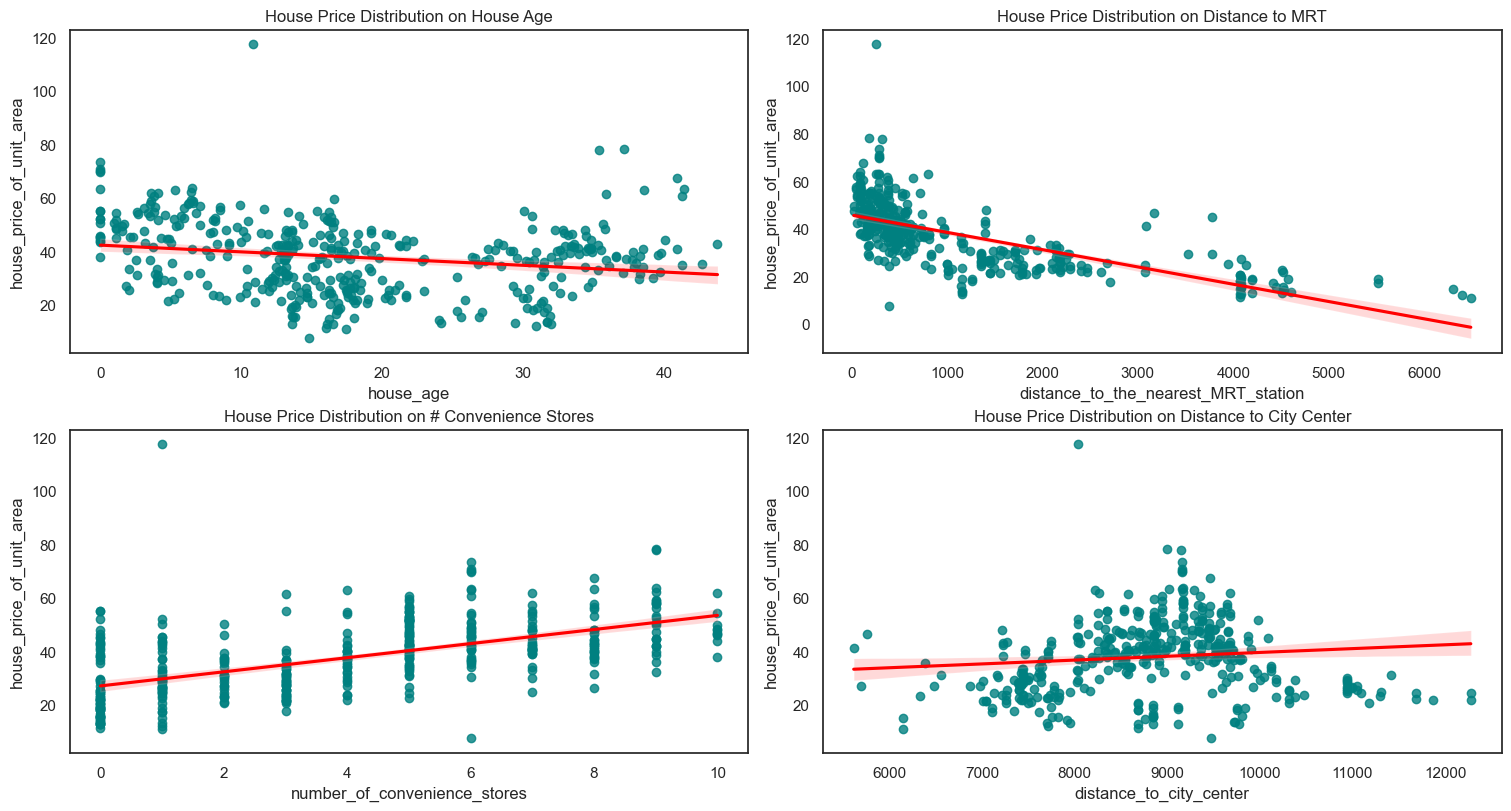

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

eda_plot, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,8), layout="constrained")

eda1_fig = sns.regplot(x=real_estate_data['house_age'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'}, ax=ax[0,0])
eda2_fig = sns.regplot(x=real_estate_data['distance_to_the_nearest_MRT_station'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'}, ax=ax[0,1])
eda3_fig = sns.regplot(x=real_estate_data['number_of_convenience_stores'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'}, ax=ax[1,0])
eda4_fig = sns.regplot(x=real_estate_data['distance_to_city_center'], y=real_estate_data['house_price_of_unit_area'], scatter_kws={'color': 'teal'}, line_kws={'color': 'red'}, ax=ax[1,1])
ax[0, 0].set_title('House Price Distribution on House Age')
ax[0, 1].set_title('House Price Distribution on Distance to MRT')
ax[1, 0].set_title('House Price Distribution on # Convenience Stores')
ax[1, 1].set_title('House Price Distribution on Distance to City Center')
plt.show()

A worth mentioning caution is that upon investigation by plotting OLS on the squared variables, it seems there is no actual non-linear pattern between the house price and those variables. By including the squared terms, we may experience overfitting on the holdout data; although in this sample, we can see it does help improving the model performance. 

###### LASSO

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# alpha
alpha = np.linspace(0.1, 10.0, num=100)

# define cv search
lasso_search = GridSearchCV(
    ElasticNet(l1_ratio = 1, fit_intercept = True),
    {"alpha":alpha},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=True,
)
preprocessing = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ], remainder='passthrough'
)

lasso_model = Pipeline(
        [("preprocess", preprocessing),
         ('interaction', PolynomialFeatures(degree=2, interaction_only=True,  include_bias=False)),
         ('scaling', StandardScaler()),
         ("regressor", lasso_search)
         ], verbose=True
)

lasso_model.fit(X_train, y_train)

update_summary(summary_df, lasso_model, 'Linear Regression w. LASSO', X_train, X_test, y_train, y_test)
summary_df

[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ....... (step 2 of 4) Processing interaction, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.0s
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Pipeline] ......... (step 4 of 4) Processing regressor, total=   0.8s


,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153
3,Linear Regression w. Engineered Features,6.6811,7.8750
4,Linear Regression w. LASSO,7.4449,6.5936


In [14]:
lasso_search.best_params_

{'alpha': 1.0}

The LASSO model considers the engineered features without squared terms, but includes all possible combinations of interaction terms. The Lasso model performs better with the holdout set but it's not able to fit the training set better than the linear model with engineered features. However, it's possible that the linear model with engineered features is overfit on the training data due to no regularization applied.

##### 2. Training more flexible models

###### Random Forest

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# build search for RF
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [0.05, 0.2, 0.5, 1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
tune_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state = prng),
    param_distributions=tune_grid,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=True,
    random_state=prng, 
    n_jobs=-1
)

rf_model = Pipeline(
        [("preprocess", preprocessing),
         ("regressor", rf_search)
         ], verbose=True
)

rf_model.fit(X_train, y_train)

update_summary(summary_df, rf_model, 'Random Forest Regression', X_train, X_test, y_train, y_test)
summary_df

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  15.4s


,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153
3,Linear Regression w. Engineered Features,6.6811,7.8750
4,Linear Regression w. LASSO,7.4449,6.5936
5,Random Forest Regression,2.5061,6.9201


In [16]:
rf_search.best_params_

{'n_estimators': 670,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 25,
 'bootstrap': False}

The random forest model considers the same predictors as the LASSO model, except for the interation terms. The random forest model does a great job on the training data with the RMSE of 2.5 unit price, better than any other previous model. However, it does a slightly worse job on the holdout data than the LASSO model. 

###### GBM

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# build search for RF
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [0.05, 0.2, 0.5, 1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
gbm_tune_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gbm_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(learning_rate=0.01, random_state = prng, criterion='friedman_mse'),
    param_distributions=gbm_tune_grid,
    n_iter=200,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=True,
    random_state=prng, 
    n_jobs=-1
)

gbm_model = Pipeline(
        [("preprocess", preprocessing),
         ("regressor", gbm_search)
         ], verbose=True
)

gbm_model.fit(X_train, y_train)

update_summary(summary_df, gbm_model, 'GBM Regression', X_train, X_test, y_train, y_test)
summary_df

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  13.5s


,Model,Train RMSE,Holdout RMSE
0,Benchmark,12.3012,12.7846
1,Simple Linear Regression,8.4990,9.3673
2,Multivariate Linear Regression,6.8995,9.4153
3,Linear Regression w. Engineered Features,6.6811,7.8750
4,Linear Regression w. LASSO,7.4449,6.5936
5,Random Forest Regression,2.5061,6.9201
6,GBM Regression,1.9542,6.3516


In [18]:
gbm_search.best_params_

{'n_estimators': 230,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 25}

The gradient boosting model considers the same predictors as the random forest model. The gradient boosting model is the best model among all models built. It excels in both the training data and holdout data at predicting the house price for both the training and holdout set with the low RMSE of 1.95 and 6.35 respectively.

#### Would you launch your web app now? What options you might have to further improve the prediction performance?

Since the gradient boosting model performing a lot better than the benchmark model, it seems safe to launch the web app with it. With the mean price of the data set is around 38 unit price, a RMSE of 6.35 means our prediction if off by ~15% on average. We think this is a good starting figure to launch the website.

To improve the prediction performance, we can consider some of the following options:
- Increase the training size to better generalize the data.
- Extend the tuning parameter search to find the best hyperparameters for the models. In the random forest and GBM, we are only do a randomized search CV for faster runtime. It is possible to do a grid search to iterate through all possible combinations of hyperparameters.
- Try out even more flexible models to find the best model building methods.

#### Rerun three of your previous models (including both flexible and less flexible ones) on the full train set. Ensure that your test result remains comparable by keeping that dataset intact. (Hint: extend the code snippet below.) Did it improve the predictive power of your models? Where do you observe the biggest improvement? Would you launch your web app now?

In [19]:
real_estate_full = real_estate_data.loc[~real_estate_data.index.isin(X_test.index)]
print(f"Size of the full training set: {real_estate_full.shape}")

Size of the full training set: (389, 11)


In [20]:
y_train_full = real_estate_full["house_price_of_unit_area"]
X_train_full = real_estate_full.drop(columns=["house_price_of_unit_area", "id", "transaction_date", "transaction_year"])

In [21]:
# refit the linear model with engineered features
fe_multi_model.fit(X_train_full, y_train_full)

full_summary_df = pd.DataFrame({'Model': ['Linear Regression w. Engineered Features'],
                              'Train RMSE': ['{:.4f}'.format(root_mean_squared_error(y_train_full, fe_multi_model.predict(X_train_full)))],
                              'Holdout RMSE': ['{:.4f}'.format(root_mean_squared_error(y_test, fe_multi_model.predict(X_test)))]
                              })

# refit the RF
rf_model_full = Pipeline(
        [("preprocess", preprocessing),
         ("regressor", RandomForestRegressor(random_state = prng,
                                             n_estimators = rf_search.best_params_['n_estimators'],
                                             max_features = rf_search.best_params_['max_features'],
                                             max_depth = rf_search.best_params_['max_depth'],
                                             min_samples_split = rf_search.best_params_['min_samples_split'],
                                             min_samples_leaf = rf_search.best_params_['min_samples_leaf'],
                                             bootstrap = rf_search.best_params_['bootstrap']))
         ], verbose=True
)
rf_model_full.fit(X_train_full, y_train_full)

update_summary(full_summary_df, rf_model_full, 'Random Forest Regression', X_train_full, X_test, y_train_full, y_test)

# refit the GBM
gbm_model_full = Pipeline(
        [("preprocess", preprocessing),
         ("regressor", GradientBoostingRegressor(learning_rate=0.01, 
                                                 random_state = prng, 
                                                 criterion='friedman_mse',
                                                 n_estimators = gbm_search.best_params_['n_estimators'],
                                                 max_features = gbm_search.best_params_['max_features'],
                                                 max_depth = gbm_search.best_params_['max_depth'],
                                                 min_samples_split = gbm_search.best_params_['min_samples_split'],
                                                 min_samples_leaf = gbm_search.best_params_['min_samples_leaf']))
         ], verbose=True
)
gbm_model_full.fit(X_train_full, y_train_full)

update_summary(full_summary_df, gbm_model_full, 'GBM Regression', X_train_full, X_test, y_train_full, y_test)

full_summary_df

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.6s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.2s


,Model,Train RMSE,Holdout RMSE
0,Linear Regression w. Engineered Features,7.8377,7.1181
1,Random Forest Regression,3.1405,5.0222
2,GBM Regression,2.5377,4.7104


By including more training data, the models' performances are indeed better. The biggest jump in improvement is observed when changing the model from linear model to ensemble model like random forest. Between the 2 ensemble models, the gradient boosting model still perform relatively better. With the best RMSE on unobserved data of 4.7, our current best prediction now is only off by ~12% on average. This is a better figure to launch the webapp with the gradient boosting model.